# Chaines de Markov et épidémiologie : propagation d’une épidémie dans une population


L’objectif de ce projet est de manipuler des chaînes de Markov pour étudier la propagation d’une épidémie dans une population.

## Partie 1 : Apprentissage des paramètres d’un modèle à partir de données

Dans notre modèle, nous allons considérer qu’à chaque temps :
- chaque individu sain peut rester sain ou devenir infecté
- chaque individu infecté peut rester infecté ou devenir guéri
- chaque individu guéri reste guéri

et que la probabilité de passer d’un état à l’autre **ne dépend que de l’état précédent**.

Nous disposons d’une séquence d’observations et nous souhaitons apprendre les paramètres de la chaîne de Markov permettant de modéliser le processus sous-jacent qui a généré la séquence.

En suivant un individus pendant 10 on obtient donc la sequence d'observation suivante : $S, S, S, I, I ,I ,I , I, I, R$

On peut donc en deduire la matrice de probabilité de transition suivante :

|  |S | I | R |
| :--|:--:| :--:|--:|
|S   | 2/3 |1/3  |0|
|I   | 1/6 | 5/6 |0|
|R   |0    |  0  |1|


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

#Quelques fonction utlies que nous utiliserons par la suite

#Trace un graphique
def graph(x, y ,titre):
    plt.figure(figsize=(5, 3))
    plt.title(titre)
    plt.plot(x, y[:,0], label='Sain (S)')
    plt.plot(x, y[:,1], label="Infecté (I)")
    plt.plot(x, y[:,2], label="Guéri (R)")
    plt.xlabel("Temps t")
    plt.ylabel("Probabilités des états")
    plt.legend()
    plt.show()

Nous avons ensuite suivis une population de 5000 individus, pendant 200 jours, et obtenons donc la matrice de probabilité de transitions suivante :

In [2]:
data = np.loadtxt("data_ex1.txt", dtype =int) # Lecture des données

# 0 --> Sain (S)
# 1 --> Infecté (I)
# 2 --> Guéri (R)

def probas(data):
    m = np.zeros((3,3), dtype= float) #Création d'une matrice initialisée à 0
    prec = 9 #Declaration d'une variable précédent


    for individu in data : 
        for state in individu :
            if prec == 9 : #Si c'est la premiere valeur pour un individu on passe au suivant et on le met dans le precedent
                prec = state
                continue
            else : # Sinon on compte la transition dans la matrice m (precedent -> state)
                m[prec][state]+=1
            prec = state
        prec = 9 #A la fin de chaque individu il n'y a plus de precedent

    sum = np.sum(m,axis=1) #On somme toute les lignes
    
    for i in range(3) :
        for j in range(3) :
            m[i][j] = m[i][j]/sum[i] #On chaque case par le nombre total de transition dans une ligne
    
    return m
            


matrice = probas(data)
print(matrice)

[[0.93082918 0.06917082 0.        ]
 [0.         0.93518148 0.06481852]
 [0.04065945 0.         0.95934055]]


## Partie 2 : Description du premier modèle


Grâce au graphe de transition du document 1 on obtient la matrice de transition A suivante :

|  |S | I | R |
| :--|:--:| :--:|--:|
|S   |0.92 | 0.08 |  0 |
|I   | 0   | 0.93 |0.07|
|R   |  0  |  0   |  1 |

In [3]:
A = [[0.92,0.08,0],[0,0.93,0.07],[0,0,1]]
print(A)

[[0.92, 0.08, 0], [0, 0.93, 0.07], [0, 0, 1]]


Verifions si elle est stochastique

In [4]:
def stochastique(matrice) :
    # Verifie si toute les valeurs sont >= 0 et que la sommme de chaque ligne est égale à 1
    return np.all(matrice >= 0 ) and np.all(np.sum(matrice, axis=1)) == 1

print(stochastique(matrice))

True


Au temps $t = 0$, un individu a une probabilité de 0.9 d’être sain et 0.1 d’être infecté.
Soit $\pi_0$ la distribution de la probabilité initiale.

On a donc $\pi_0 = [0.9;0.1;0]$

In [5]:
pi0 = [0.9,0.1,0]
print("pi0 = ",pi0)

pi0 =  [0.9, 0.1, 0]


### Distribution :

Au temps $t = 1$ on a donc $\pi_0 \times A$ donc $\pi_1 = [0.828;0.165;0.007]$

In [6]:
pi1 = np.dot(pi0,A)
print("pi1 =",pi1)

pi1 = [0.828 0.165 0.007]


Au temps $t = 2$ on a donc $\pi_1 \times A$ donc $\pi_2 = [0,76176;0,21969;0,01855]$

In [7]:
pi2 = np.dot(pi1,A)
print("pi2 = ",pi2)

pi2 =  [0.76176 0.21969 0.01855]


Afin de calculer la distribution theorique des effectifs dans chaque états on doit donc calculer $\pi_t$ à chaque temps $t$
On a donc
$$ \pi_{t+1}=\pi_{t}\times A = (\pi_{t-1}\times A)\times A = \pi_0 \times A^t $$

(200, 3)


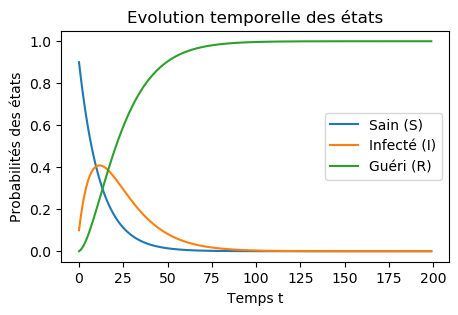

In [8]:
def distribution(pi,a,t):
    # Calcule la distribution théorique suivant un temps t
    return np.matmul(pi,np.linalg.matrix_power(a,t))


T = np.arange(200)
pit = np.zeros((200, 3))
for i in range(0, 200):
    pit[i] = distribution(pi0,A,i)

print(pit.shape)

graph(T, pit,"Evolution temporelle des états")


On observe donc que le taux de personne saine decroit très rapidement suivant le temps, tandis que le taux de de personne guéri croit. Le taux de personnes infectées connait un pic et decroit rapidement.

### Tirage aléatoire des états

Nous allons maintenant générer une séquence de taille T en utilisant cette chaine de Markov. Pour générer cette séquence aléatoire, nous allons choisir un état initial au hasard; puis choisir les états suivants en suivant les probabilités de transition.

In [9]:
def gen_sequences(A,pi, t):
    #Genere une sequence aléatoire pour un individu sur un temps t
    seq = np.zeros(t)
    seq[0] = np.random.choice([0.,1.,2.],1, p = pi)
    for i in range(1,t):
        seq[i] = np.random.choice([0.,1.,2.],1, p=A[int(seq[i-1])])
    return seq

print(gen_sequences(A,pi0,150))



[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2.]


### Modélisation d'une population

Modélisons maintenant une une séquence d'état pour une population de 200 individus.

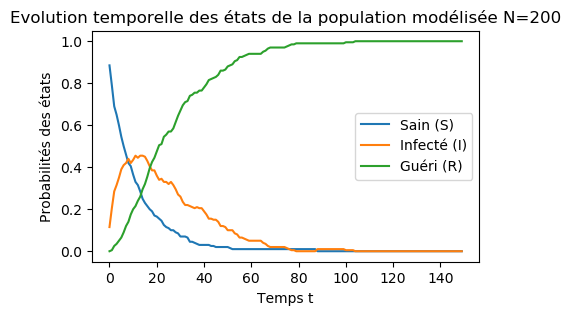

In [10]:
def gen_sequences_population(A,pi,n, t):
    #Genere des sequences aléatoires pour une population de taille n sur un temps t
    seq = np.zeros((n,t))
    for i in range(n):
        seq[i] = gen_sequences(A, pi, t)
    return seq

p=gen_sequences_population(A,pi0,200,150)


def compteur(sequence,t):
    res = np.zeros((t,3))
    for i in range (len(sequence)):
        for j in range (len(sequence[0])):
            if sequence[i][j] == 0:
                res[j][0]+=1
            if sequence[i][j] == 1:
                res[j][1]+=1
            if sequence[i][j] == 2:
                res[j][2]+=1
    res/=200
    return res

repartition = compteur(p,150)
T = np.arange(150)
graph(T,repartition,"Evolution temporelle des états de la population modélisée N=200")

On remarque donc que quand t est grand le taux de personnes saines et infectées sont nulle tandis que le taux de personnes infectées est au maximum.

Avec une population de taille 5 nous retrouvons le graphe suivant :

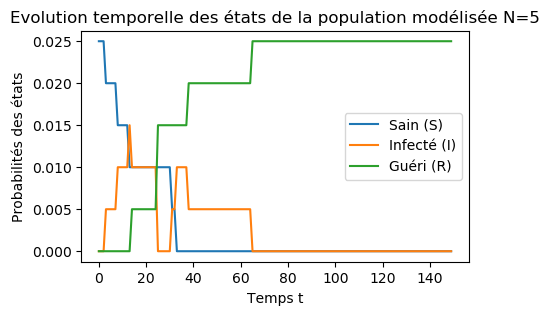

In [11]:
pop5 = compteur(gen_sequences_population(A,pi0,5,150),150)
graph(T, pop5, "Evolution temporelle des états de la population modélisée N=5")

Avec une population de taille 5000 nous retrouvons le graphe suivant :

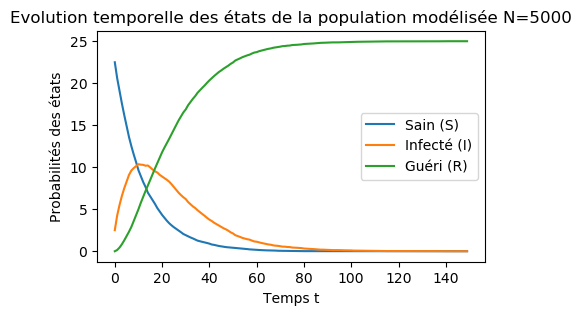

In [12]:
pop5 = compteur(gen_sequences_population(A,pi0,5000,150),150)
graph(T, pop5, "Evolution temporelle des états de la population modélisée N=5000")

On remarque que les resultats retrouvés avec une population de taille 5, de taille 200 et de taille 5000 se ressemblent quand t est grand.

### Longueur de l'infection

